# Message comparison between VB and ALBU messages from Polya to Dirichlet nodes
Here we compare the approximate messages from a Polya to Dirichlet node as calculated by the VMP (VB), ALBU and hierachical sampling.

In [9]:
%matplotlib inline 
import numpy as np
import scipy as sc
from matplotlib import pylab as plt
from scipy.special import gamma, digamma, polygamma
from scipy import integrate
from scipy.special import digamma, polygamma

In [10]:
# Approximates KL divergence for 1-D continuous p and q by using numerical integration. 
# Both p and q are continuous probability distributions over RV X. 
# We only know their values at sampled points x.

def kl1_cont_PQ(p,q,x):
    K = len(p)
    theProd = np.zeros(K)
    for k in range(0,K):
        if p[k] > 0.0:
            theProd[k] = p[k]*np.log(p[k]/q[k])
    return integrate.simps(theProd, x, dx=1, axis=-1, even='avg')

def kl1_cont_QP(p,q,x):
    K = len(p)
    theProd = np.zeros(K)
    for k in range(0,K):
        theProd[k] = q[k]*np.log(q[k]/p[k])
    return integrate.simps(theProd, x, dx=1, axis=-1, even='avg')




In [14]:
def run_comparison_of_approx_methods(pX=np.array([0.2,0.8]),a=np.array([0.5,0.5]),only_message=True):
    da = 0
    # normalisation
    ac = gamma(np.sum(a))/np.prod(gamma(a))
    capX = pX.dot(a)/sum(a)

    # sampling of the probs theta0 and theta1
    q1 = np.linspace(5E-5,1.-5E-5,1000)
    q0 = 1. - q1

    # the dirichlet distribution
    f0 = ac*np.power(q0,a[0])*(np.power(q1,a[1]-1.))
    f1 = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]))

    # The *** true posterior marginal *** after we summed out X (p)
    fP = (pX[0]*f0+pX[1]*f1)/capX
    f = ac*np.power(q0,a[0]-1.)*(np.power(q1,a[1]-1.))
    area = sc.integrate.simps(fP, q1, dx=1, axis=-1, even='avg')
    fP = fP/area;
    m_pd = fP/f

    # ALBU approximation (close to hierachical sampling)
    emdw_a = a*pX;
    emdw_a /= np.sum(emdw_a) 
    alphas_em = emdw_a

    # VB approximation
    new_aa = np.ones(2)
    for i in range(len(new_aa)):
        new_aa[i] = np.exp(digamma(a[i]) - digamma(np.sum(a)))*pX[i]
    new_aa /=np.sum(new_aa)
    vb_a = new_aa
    
    # if we are plotting the posterior, add the original alphas
    if only_message is False:
        emdw_a = emdw_a + a
        vb_a = vb_a + a

    aa_emdw = np.array(emdw_a)
    aa_vb = np.array(vb_a)

    caa_emdw = gamma(np.sum(aa_emdw))/np.prod(gamma(aa_emdw))
    caa_vb = gamma(np.sum(aa_vb))/np.prod(gamma(aa_vb))

    # ALBU approximate
    fQ_emdw = caa_emdw*np.power(q0,aa_emdw[0]+da-1.)*(np.power(q1,aa_emdw[1]-da-1.))
    area = sc.integrate.simps(fQ_emdw, q1, dx=1, axis=-1, even='avg')
    fQ_emdw /= area;
    
    # VB approximate
    fQ_vb = caa_vb*np.power(q0,aa_vb[0]+da-1.)*(np.power(q1,aa_vb[1]-da-1.))
    areab = sc.integrate.simps(fQ_vb, q1, dx=1, axis=-1, even='avg')
    fQ_vb /= areab;

    return q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd

def plot_posterior(q0=None, q1=None, fP=None, fQ_emdw=None, fQ_minka=None,  fQ_vb=None,figstring=""):

    truePost,= plt.plot(q1,fP,label='True',color='blue')
    estPost_e,= plt.plot(q1,fQ_emdw,label='ALBU/VMP+/Sampling estimate',color='green')
    estPost_vb,= plt.plot(q1,fQ_vb,label='VMP estimate',color='orange')

    plt.rc('text', usetex=True)
    plt.xlabel(r'$\theta_2$ \hspace{5mm} (with $\theta_1 = 1-\theta_2$)',fontsize=16)
    plt.ylabel(r'$p(\theta_1|\alpha,p_1,p_2)$',
              fontsize=16)
#     plt.title(r'Posterior Dirichlet distribution with $\alpha_0=$%s, $\alpha_1=$%s, $p_0=$%s, $p_1=$%s'%(a[0],a[1],pX[0],pX[1]))
    plt.legend(handles=[truePost,estPost_e, estPost_vb])
    plt.ylim((0,4))
    plt.grid()
    plt.savefig("posterior_"+figstring+".pdf")
    plt.show()

def plot_kl_div(del_a=np.linspace(-0.25,0.25,100), emdw_a=None, vb_a=None, fP=None,figstring=""):
    da=0
    div_emdw = np.zeros(len(del_a))
    div_act = np.zeros(len(del_a))
    div_vb = np.zeros(len(del_a))
    div_emdw_QP = np.zeros(len(del_a))
    div_vb_QP = np.zeros(len(del_a))
    for k in range( len(del_a) ):

        aa_emdw = np.array(emdw_a)
        aa_vb = np.array(vb_a)
        
        aa_emdw[0] += del_a[k]
        aa_emdw[1] -= del_a[k]
        aa_vb[0] += del_a[k]
        aa_vb[1] -= del_a[k]
            
        caa_emdw = gamma(np.sum(aa_emdw))/np.prod(gamma(aa_emdw))
        caa_vb = gamma(np.sum(aa_vb))/np.prod(gamma(aa_vb))
        
        fQ = caa_emdw*np.power(q0,aa_emdw[0]+da-1.)*(np.power(q1,aa_emdw[1]-da-1.))
        area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
        fQ /= area; #renormalize for the sake of simpson's rule
        div_emdw[k] = kl1_cont_PQ(fQ,fP,q1)
        div_emdw_QP[k] = kl1_cont_QP(fQ,fP,q1)
        
        fQ = caa_vb*np.power(q0,aa_vb[0]+da-1.)*(np.power(q1,aa_vb[1]-da-1.))
        area = sc.integrate.simps(fQ, q1, dx=1, axis=-1, even='avg')
        fQ /= area; #renormalize for the sake of simpson's rule
        div_vb[k] = kl1_cont_PQ(fQ,fP,q1)
        div_vb_QP[k] = kl1_cont_QP(fQ,fP,q1)
        

    plt.figure(1)
    plt.plot(del_a,div_emdw,color='green') 
    plt.plot(del_a,div_vb,color='brown') 
    plt.plot(del_a,div_emdw_QP,color='green', linestyle='dashed') 
    plt.plot(del_a,div_vb_QP,color='brown', linestyle='dashed') 
    plt.xlabel(r'Delta $\alpha$',fontsize=16)
    plt.ylabel('KL(Q,P)',fontsize=16)
#     plt.title(r'KL divergences vs delta alpha with $\alpha_1=$%s, $\alpha_2=$%s, $p_1=$%s, $p_2=$%s'%(a[0],a[1],pX[0],pX[1]))
    plt.savefig("KL_" + figstring +".pdf")
    plt.xlim(-0.25, 0.25)
    plt.grid(True)
    plt.show()
    




#### Set stuff up
You can play around with these. 

alpha_0=0.6 ,alpha_1=0.4 ,p_0=0.1 ,p_=0.9


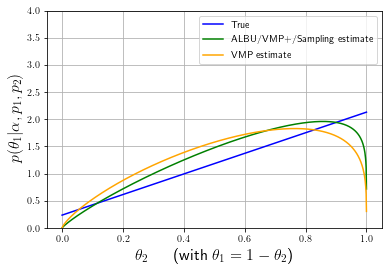

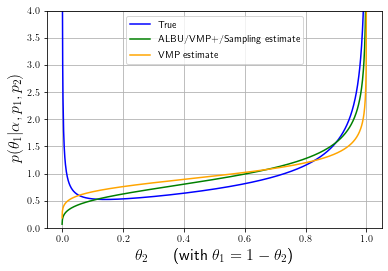

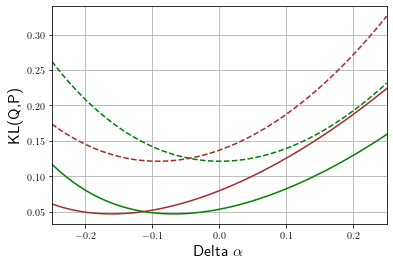

In [15]:
alphas_const = 1

pX = np.array([0.1,0.9]) # distribution (incoming from right) p(X|Y=y)
a1 = 0.6
a2 = 1-a1
a = np.array([a1,a2])*alphas_const  # distribution (incoming from left) p(theta;alpha)
del_a = np.linspace(-0.25,0.25,100)
figstring = "alpha_0="+str(a[0])+" ,alpha_1="+str(a[1])+" ,p_0="+str(pX[0])+" ,p_="+str(pX[1])
q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a)
q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a, only_message=False)
f = fP/m_pd
plot_posterior(q0=q0, q1=q1, fP=fP/f, fQ_emdw=fQ_emdw/f,fQ_vb=fQ_vb/f, figstring=figstring+"nm_msg")
plot_posterior(q0=q0, q1=q1, fP=fP, fQ_emdw=fQ_emdw, fQ_vb=fQ_vb, figstring=figstring)
plot_kl_div(del_a=del_a, emdw_a=emdw_a, vb_a=vb_a, fP=fP,figstring=figstring)


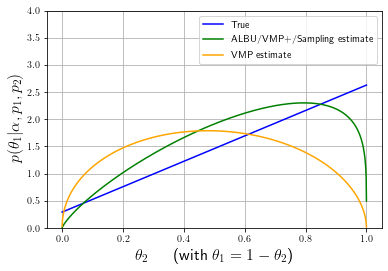

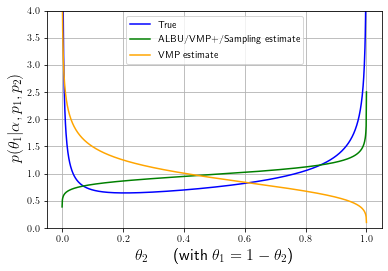

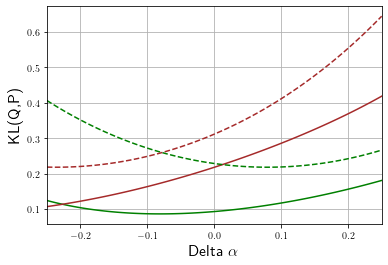

In [16]:
pX = np.array([0.1,0.9]) # distribution (incoming from right) p(X|Y=y)
a1 = 0.7
a2 = 1-a1
a = np.array([a1,a2])*alphas_const  # distribution (incoming from left) p(theta;alpha)
del_a = np.linspace(-0.25,0.25,100)
figstring = "alpha_0="+str(a[0])+" ,alpha_1="+str(a[1])+" ,p_0="+str(pX[0])+" ,p_="+str(pX[1])
q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a)
q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a, only_message=False)
f = fP/m_pd
plot_posterior(q0=q0, q1=q1, fP=fP/f, fQ_emdw=fQ_emdw/f,fQ_vb=fQ_vb/f, figstring=figstring+"nm_msg")
plot_posterior(q0=q0, q1=q1, fP=fP, fQ_emdw=fQ_emdw, fQ_vb=fQ_vb, figstring=figstring)
plot_kl_div(del_a=del_a, emdw_a=emdw_a, vb_a=vb_a, fP=fP,figstring=figstring)

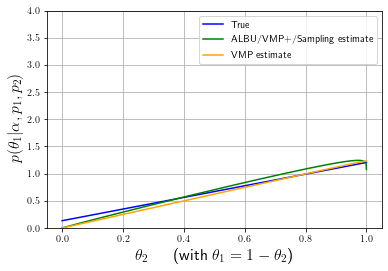

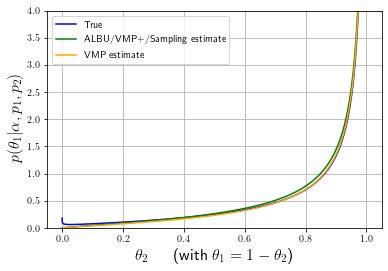

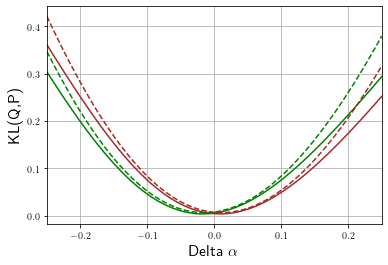

In [17]:
pX = np.array([0.1,0.9]) # distribution (incoming from right) p(X|Y=y)
a1 = 0.2
a2 = 1-a1
a = np.array([a1,a2])*alphas_const  # distribution (incoming from left) p(theta;alpha)
del_a = np.linspace(-0.25,0.25,100)
figstring = "alpha_0="+str(a[0])+" ,alpha_1="+str(a[1])+" ,p_0="+str(pX[0])+" ,p_="+str(pX[1])
q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a)
q0, q1, fP, fQ_emdw, fQ_vb, emdw_a, vb_a, m_pd =run_comparison_of_approx_methods(pX=pX,a=a, only_message=False)
f = fP/m_pd
plot_posterior(q0=q0, q1=q1, fP=fP/f, fQ_emdw=fQ_emdw/f,fQ_vb=fQ_vb/f, figstring=figstring+"nm_msg")
plot_posterior(q0=q0, q1=q1, fP=fP, fQ_emdw=fQ_emdw, fQ_vb=fQ_vb, figstring=figstring)
plot_kl_div(del_a=del_a, emdw_a=emdw_a, vb_a=vb_a, fP=fP,figstring=figstring)